In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", False)
device = "cpu"
config.update("jax_platform_name", device)

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax.numpy as jnp
from jax import jit, value_and_grad, vmap
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import jaxley as jx
from jaxley.channels import HH
from jaxley.utils.colors import network_cols

In [3]:
from neuron import h

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

--No graphics will be displayed.


In [5]:
nseg_per_branch = 4

i_delay = 3.0  # ms
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 20.0  # ms

In [6]:
def read_cell(fname):
    cell = jx.read_swc(fname, nseg_per_branch, max_branch_len=2000.0, assign_groups=True)
    
    for b, c in zip(rec_branches, rec_comps):
        cell.branch(b).loc(c).record()
    
    for branch_num in range(1, len(cell.comb_parents)):
        for comp in range(nseg_per_branch):
            cell.branch(branch_num).comp(comp).set("radius", neuron_radiuses[nseg_per_branch * neuron_to_jaxley_branch_mapping[branch_num] + comp])
            
    cell.rotate(rotation)
    cell.insert(HH())
    cell.set("axial_resistivity", 1_000.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)
    return cell

### Helpers for getting the radiuses right

In [7]:
def get_neuron_radius(fname):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    neuron_radiuses = []
    for i, sec in enumerate(h.allsec()):
        rads_in_sec = []
        for seg in sec:
            neuron_radiuses.append(seg.diam)
    neuron_radiuses = np.asarray(neuron_radiuses) / 2
    return neuron_radiuses


def get_mapping(fname):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch
    
    neuron_pathlengths = np.asarray([sec.L for sec in h.allsec()])
    
    neuron_to_jaxley_branch_mapping = []
    for i, p in enumerate(jx_pathlengths):
        closest_match = np.argmin(np.abs(neuron_pathlengths - p))
        max_dist = np.min(np.abs(neuron_pathlengths - p))
        assert max_dist < 2e-4, f"{i}, max_dist {max_dist}"
        neuron_to_jaxley_branch_mapping.append(closest_match)
    neuron_to_jaxley_branch_mapping = np.asarray(neuron_to_jaxley_branch_mapping)
    return neuron_to_jaxley_branch_mapping

### Panel B

NEURON

In [8]:
def simulate_neuron(i_amp):
    for sec in h.allsec():
        h.delete_section(sec=sec)
        
    cell_neuron = h.Import3d_SWC_read()
    cell_neuron.input(fname)
    i3d = h.Import3d_GUI(cell_neuron, False)
    i3d.instantiate(None)
    
    for sec in h.allsec():
        sec.nseg = nseg_per_branch

    pathlengths_neuron = np.asarray([sec.L for sec in h.allsec()])
    
    for branch_ind, sec in enumerate(h.allsec()):
        if branch_ind > 0:
            for comp, seg in enumerate(sec):
                seg.diam = 2 * neuron_radiuses[nseg_per_branch * branch_ind + comp]
    
    for i, sec in enumerate(h.allsec()):
        if i == 0:
            stim = h.IClamp(sec(0.2))
            stim.delay = i_delay
            stim.dur = i_dur
            stim.amp = i_amp
    
    counter = 0
    voltage_recs = {}
    for b, c in zip(neuron_to_jaxley_branch_mapping[rec_branches], rec_comps):
        for i, sec in enumerate(h.allsec()):
            if i == b:
                v = h.Vector()
                v.record(sec(c)._ref_v)
                voltage_recs[f"v{counter}"] = v
                counter += 1
    
    for sec in h.allsec():
        sec.insert("hh")
        sec.Ra = 1_000.0
    
        sec.gnabar_hh = 0.120  # S/cm2
        sec.gkbar_hh = 0.036  # S/cm2
        sec.gl_hh = 0.0003  # S/cm2
        sec.ena = 50  # mV
        sec.ek = -77.0  # mV
        sec.el_hh = -54.3  # mV
    
    h.dt = dt
    tstop = t_max
    v_init = -62.0
    
    def initialize():
        h.finitialize(v_init)
        h.fcurrent()
    
    def integrate():
        while h.t < tstop:
            h.fadvance()
    
    initialize()
    integrate()
    voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])
    return voltages_neuron

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


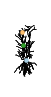

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


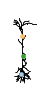

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


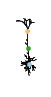

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


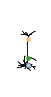

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


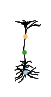

In [9]:
recording_sites = {
    "n144": [[0, 34, 54], [0.8, 0.8, 0.8], 0, [-200, 200], [-350, 650]],
    "485574832": [[0, 60, 68], [0.2, 0.6, 0.6], 160, [-400, 0], [-900, -100]],
    "480351780": [[0, 66, 71], [0.2, 0.6, 0.6], 220, [-850, -450], [-550, 450]],
    "484559000": [[0, 35, 37], [0.2, 0.8, 0.8], 155, [-350, 50], [-850, 150]],
    "488683425": [[0, 61, 63], [0.2, 0.8, 0.8], 198, [-750, -350], [-750, 250]],
}

every_neuron_amp_j = []
every_neuron_time_j = []
every_neuron_amp_n = []
every_neuron_time_n = []

for site in recording_sites.keys():
    rec_branches = recording_sites[site][0]
    rec_comps = recording_sites[site][1]
    rotation = recording_sites[site][2]
    xlim = recording_sites[site][3]
    ylim = recording_sites[site][4]
    
    fname = f"../morphologies/{site}.swc"

    # Getting mapping of branches between NEURON and Jaxley.
    _, jx_pathlengths, _, _, _ = jx.utils.swc.swc_to_jaxley(fname, max_branch_len=2000.0)
    neuron_radiuses = get_neuron_radius(fname)
    neuron_to_jaxley_branch_mapping = get_mapping(fname)

    cell = read_cell(fname)
    with mpl.rc_context(fname="../../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, figsize=(0.4, 0.4 * 2.5))
        ax = cell.vis(ax=ax, morph_plot_kwargs={"linewidth": 0.3})
        counter = 0
        cols = ["#a6cee3", "#33a02c", "#fdbf6f"]
        for b, c in zip(rec_branches, rec_comps):
            ax = cell.branch(b).loc(c).vis(ax=ax, col=cols[counter], morph_plot_kwargs={"zorder": 1000, "linewidth": 0.3})
            counter += 1
        _ = ax.set_xlim(xlim)
        _ = ax.set_ylim(ylim)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.spines["left"].set_visible(False)
        _ = ax.spines["bottom"].set_visible(False)
        plt.savefig(f"../svg/appendix_panel_morph_{site}.svg", transparent=True, bbox_inches="tight")
        plt.show()

    def simulate_jaxley(i_amp):
        current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
        ds = cell.branch(0).loc(0.2).data_stimulate(current, None)
        return jx.integrate(cell, delta_t=dt, data_stimuli=ds, voltage_solver="jaxley.stone")
    jitted_sim = jit(simulate_jaxley)

    all_spike_amplitude_jaxley = []
    all_spike_time_jaxley = []
    all_spike_amplitude_neuron = []
    all_spike_time_neuron = []

    for i_amp in np.arange(0.2, 1.11, 0.1):
        voltages_jaxley = jitted_sim(i_amp)
        voltages_neuron = simulate_neuron(i_amp)

        time_vec = jnp.arange(0, t_max+2*dt, dt)

        jaxley_argmax = np.argmax(voltages_jaxley, axis=1)
        neuron_argmax = np.argmax(voltages_neuron, axis=1)

        spike_times_jaxley = time_vec[jaxley_argmax]
        spike_times_neuron = time_vec[neuron_argmax]

        spike_amplitude_jaxley = np.asarray([v[j] for v, j in zip(voltages_jaxley, jaxley_argmax)])
        spike_amplitude_neuron = np.asarray([v[j] for v, j in zip(voltages_neuron, neuron_argmax)])

        all_spike_amplitude_jaxley.append(spike_amplitude_jaxley)
        all_spike_amplitude_neuron.append(spike_amplitude_neuron)
        all_spike_time_jaxley.append(spike_times_jaxley)
        all_spike_time_neuron.append(spike_times_neuron)

    every_neuron_amp_j.append(np.asarray(all_spike_amplitude_jaxley))
    every_neuron_amp_n.append(np.asarray(all_spike_amplitude_neuron))
    every_neuron_time_j.append(np.asarray(all_spike_time_jaxley))
    every_neuron_time_n.append(np.asarray(all_spike_time_neuron))

In [36]:
time_diff = np.max(np.abs(np.asarray(every_neuron_time_j) - np.asarray(every_neuron_time_n)))
print(f"Maximal spike time difference between neuron and jaxley {time_diff}")

amp_diff = np.max(np.abs(np.asarray(every_neuron_amp_j) - np.asarray(every_neuron_amp_n)))
print(f"Maximal spike amplitude difference between neuron and jaxley {amp_diff}")

Maximal spike time difference between neuron and jaxley 0.05000019073486328
Maximal spike amplitude difference between neuron and jaxley 0.0910114577028196


In [37]:
time_diff = np.mean(np.abs(np.asarray(every_neuron_time_j) - np.asarray(every_neuron_time_n)))
print(f"Mean spike time difference between neuron and jaxley {time_diff}")

amp_diff = np.mean(np.abs(np.asarray(every_neuron_amp_j) - np.asarray(every_neuron_amp_n)))
print(f"Mean spike amplitude difference between neuron and jaxley {amp_diff}")

Mean spike time difference between neuron and jaxley 0.010333362966775894
Mean spike amplitude difference between neuron and jaxley 0.020370199027225103


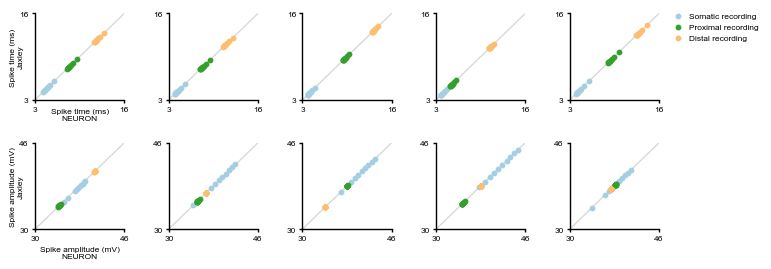

In [57]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 5, figsize=(8.05, 2.8))

    markers = ["v", "^", "<", ">", "o", "s"]
    for neuron_id in range(5):
        all_spike_time_jaxley = every_neuron_time_j[neuron_id]
        all_spike_time_neuron = every_neuron_time_n[neuron_id]
        all_spike_amplitude_jaxley = every_neuron_amp_j[neuron_id]
        all_spike_amplitude_neuron = every_neuron_amp_n[neuron_id]

        cols = ["#a6cee3", "#33a02c", "#fdbf6f"]
        for neuron, jaxley, col in zip(all_spike_time_neuron.T, all_spike_time_jaxley.T, cols):
            _ = ax[0, neuron_id].scatter(neuron, jaxley, color=col, s=10.0)
        for neuron, jaxley, col in zip(all_spike_amplitude_neuron.T, all_spike_amplitude_jaxley.T, cols):
            _ = ax[1, neuron_id].scatter(neuron, jaxley, color=col, s=10.0)
        _ = ax[0, neuron_id].plot([3, 16], [3, 16], color="gray", alpha=0.3, zorder=-1)
        _ = ax[1, neuron_id].plot([30, 46], [30, 46], color="gray", alpha=0.3, zorder=-1)
        _ = ax[0, neuron_id].set_xticks([3, 16])
        _ = ax[0, neuron_id].set_xlim([3, 16])
        _ = ax[0, neuron_id].set_yticks([3, 16])
        _ = ax[0, neuron_id].set_ylim([3, 16])
        _ = ax[1, neuron_id].set_xticks([30, 46])
        _ = ax[1, neuron_id].set_xlim([30, 46])
        _ = ax[1, neuron_id].set_yticks([30, 46])
        _ = ax[1, neuron_id].set_ylim([30, 46])

    _ = ax[0, 0].set_ylabel("Spike time (ms)\nJaxley", labelpad=-3)
    _ = ax[0, 0].set_xlabel("Spike time (ms)\nNEURON", labelpad=-3)
    _ = ax[1, 0].set_ylabel("Spike amplitude (mV)\nJaxley", labelpad=-3)
    _ = ax[1, 0].set_xlabel("Spike amplitude (mV)\nNEURON", labelpad=3)
    _ = ax[0, 4].legend(
        ["Somatic recording", "Proximal recording", "Distal recording"],
        loc="upper right",
        bbox_to_anchor=[2.2, 1.1, 0.0, 0.0],
        handletextpad=0.3,
    )
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(f"../svg/appendix_panel_accuracy.svg", transparent=True, bbox_inches="tight")
    plt.show()

# Assemble figure

In [58]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '8pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_normal = {'size': '6pt', 'font': 'Arial'}

f = Figure(
    "18.0cm",
    "6.2cm",
    Panel(
        SVG(f"../svg/appendix_panel_morph_n144.svg").scale(svg_scale).move(42, 0),
        SVG(f"../svg/appendix_panel_morph_485574832.svg").scale(svg_scale).move(161, 0),
        SVG(f"../svg/appendix_panel_morph_480351780.svg").scale(svg_scale).move(280, 0),
        SVG(f"../svg/appendix_panel_morph_484559000.svg").scale(svg_scale).move(400, 0),
        SVG(f"../svg/appendix_panel_morph_488683425.svg").scale(svg_scale).move(520, 0),
    ).move(-22, -14),
    Panel(
        SVG("../svg/appendix_panel_accuracy.svg").scale(svg_scale),
    ).move(-7, -4),
)

!mkdir -p fig
f.save("../fig/fig1_appendix_accuracy.svg")
svg("../fig/fig1_appendix_accuracy.svg")

/Users/michaeldeistler/anaconda3/envs/nex/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
